# Installing TensorFlow and Keras & Library Imports



In [ ]:
#  install.packages("tensorflow")
#  install.packages("keras")
#  install.packages("RCurl")
#  install.packages("kableExtra")
#  install.packages("reshape2")
#  install.packages("abind")
#  install.packages('reticulate')

In [1]:
library(keras)
library(tensorflow)
tf$version$VERSION  #2.6.5
library(tidyverse)
library(graphics)
library(abind)
library(reticulate)
library(randomForest)
np <- import("numpy")

Loaded Tensorflow version 2.6.5



[1] "2.6.5"

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




# DATA IMPORT AND PREPARATION

Using PathMNIST dataset from https://medmnist.com/

In [17]:
# load data
dermamnist_data <- np$load("../input/dermamnist/dermamnist.npz")

# get training data and labels
train <- dermamnist_data$f[["train_images"]]
train_label <- dermamnist_data$f[["train_labels"]]
dim(train) # check dimensions
dim(train_label)
t(sort(unique(train_label)))

# get validation data and labels
val <- dermamnist_data$f[["val_images"]]
val_label <- dermamnist_data$f[["val_labels"]]
dim(val) # check dimensions
dim(val_label)
t(sort(unique(val_label)))

# get test data and labels
test <- dermamnist_data$f[["test_images"]]
test_label <- dermamnist_data$f[["test_labels"]]
dim(test) # check dimensions
dim(test_label)
t(sort(unique(test_label)))

# convert pixel values to 0-1
X_train <- train/255
X_val <- val/255
X_test <- test/255






# define function to get one hot coded labels
to_one_hot <- function(labels, dimension = 7) {
  results <- matrix(0, nrow = length(labels), ncol = dimension)
  for (i in 1:length(labels))
    results[i, labels[[i]] + 1] <- 1
  results
}

# get one-hot coded labels
Y_train <- to_one_hot(train_label)
Y_val <- to_one_hot(val_label)
Y_test <- to_one_hot(test_label)

[1] 7007   28   28    3

[1] 7007    1

0,1,2,3,4,5,6


[1] 1003   28   28    3

[1] 1003    1

0,1,2,3,4,5,6


[1] 2005   28   28    3

[1] 2005    1

0,1,2,3,4,5,6


# Base Model VGG16

 - Use pre-trained VGG16 model
 - extract features
 - use features in Random Forest model to predict classes

In [3]:
# VGG16: edit from original keras function:
application_vgg16 = function (include_top = TRUE,
                              weights = "imagenet",
                              input_tensor = NULL,
                              input_shape = NULL,
                              pooling = NULL,
                              classes = 7){

  tf$keras$applications$VGG16(include_top = include_top, weights = weights, 
    input_tensor = input_tensor, 
    input_shape = input_shape, 
    pooling = pooling, classes = as.integer(classes))
}

In [4]:
# create VGG 16 model
base_model <- application_vgg16(weights = "imagenet",
                           include_top = FALSE,
                           input_shape = c(32L, 32L, 3L))
summary(base_model)

Model: "vgg16"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 32, 32, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 32, 32, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 32, 32, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 16, 16, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 16, 16, 128)             73856       
________________________________________________________________________________
block2_conv2 

In [6]:
# freeze weights of all convolutional VGG16 layers
freeze_weights(base_model)

In [7]:
# add flatten layer to extract features
features = base_model$output %>% layer_flatten()
model_feature <- keras_model(
    inputs = base_model$input, 
    outputs = features)

In [8]:
# define a dummy model just to add zero padding before feeding to pre-trained model
# - otherwise error in VGG because in assumes 32x32, but PathMNIST is 28x28
model_pad <- keras_model_sequential() %>% layer_zero_padding_2d(padding = 2)

# get zero-padded images
test_pad <- model_pad(X_test)
train_pad <- model_pad(X_train)
val_pad <- model_pad(X_val)

In [9]:
# define function to get features via pre-trained model (i.e., VGG16 trained on imagenet)
# - uses batches, otherwise memory issues
get_features_batch <- function(data, batchsize){
    
    # get batch sequence
    batch_seq = seq(1, dim(data)[1], batchsize)
    
    # loop over batches to get features
    for(i in batch_seq){
        # make sure that last batch ends with last datapoint
        if (i != batch_seq[length(batch_seq)]){
            batch <- data[i:(i+batchsize-1),,,]
        } else {
            batch <- data[i:dim(data)[1],,,]
        }

        # get features via pre-trained model
        features_tmp = model_feature(batch)

        # concatenate features of all batches
        if (i==1){
            features = features_tmp
        } else {
            features = tf$concat(list(features, features_tmp), axis=0L)
        }
    }
    return(features)
}

# extract features
train_features = get_features_batch(train_pad, 1000)
test_features = get_features_batch(test_pad, 1000)
val_features = get_features_batch(val_pad, 1000)


In [45]:
# use extracted features in Random Forest model to predict classes

# create dataframe with training features
df_train = data.frame(
     y = as.factor(as.character(train_label)),
     as.matrix(train_features)
)
# create dataframe with test features
df_test = data.frame(
     as.matrix(test_features)
)

# run Random Forest on training features
rf = randomForest(y ~ ., df_train)

In [46]:
# run stratified Random Forest since classes highly imbalanced
rf_stratified = randomForest(y ~ ., df_train, sampsize=c(80, 80, 80, 80, 80, 80, 80), strata=df_train$y)


In [49]:
# use Random Forest model to predict test classes
pred_rf = predict(rf, df_test)
pred_rf_stratified = predict(rf_stratified, df_test)


In [50]:
acc_rf = mean(pred_rf == as.factor(as.character(test_label)))
acc_rf_stratified = mean(pred_rf_stratified == as.factor(as.character(test_label)))

acc_rf
acc_rf_stratified

[1] 0.7236908

[1] 0.5506234

In [52]:
# get contigency table
table(test_label)
table(pred_rf)
table(pred_rf_stratified)

table(test_label, pred_rf)
table(test_label, pred_rf_stratified)

test_label
   0    1    2    3    4    5    6 
  66  103  220   23  223 1341   29 

pred_rf
   0    1    2    3    4    5    6 
  10   35  151    0   94 1711    4 

pred_rf_stratified
  0   1   2   3   4   5   6 
169 161 143  93 442 870 127 

          pred_rf
test_label    0    1    2    3    4    5    6
         0    4    8   18    0    5   31    0
         1    2   14   18    0    5   63    1
         2    3    5   78    0   19  115    0
         3    1    0    4    0    2   16    0
         4    0    1   20    0   47  155    0
         5    0    7   13    0   16 1305    0
         6    0    0    0    0    0   26    3

          pred_rf_stratified
test_label   0   1   2   3   4   5   6
         0  34  13   4   5   8   1   1
         1  20  42   8   7  14   8   4
         2  39  36  63   6  51  21   4
         3   3   1   2   8   5   3   1
         4  16   6  13   3 135  33  17
         5  57  62  52  64 228 800  78
         6   0   1   1   0   1   4  22

In [35]:
# get table of test labels
# - test data is extremely unbalanced between classes (also traning and validata data)
table(train_label)

train_label
   0    1    2    3    4    5    6 
 228  359  769   80  779 4693   99 

### Finetuning VGG Model (with frozen convolutional part)

In [84]:
# prepare new head for our 7 DermaMNIST classes 
predictions <- base_model$output %>% 
    layer_flatten() %>% 
    layer_dense(units = 100, activation = "relu") %>% 
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 7, activation = "softmax")
summary(predictions)

KerasTensor(type_spec=TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), name='dense_8/Softmax:0', description="created by layer 'dense_8'")


In [85]:
# create VGG model with 7 classes output
model <- keras_model(inputs = base_model$input, outputs = predictions)
summary(model)

Model: "model_6"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 32, 32, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 32, 32, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 32, 32, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 16, 16, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 16, 16, 128)             73856       
________________________________________________________________________________
block2_conv

In [86]:
# compile model
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

In [87]:
# train model
history <- model %>% fit(
  train_pad, Y_train, 
  epochs = 30,
  batch_size = 128,
  verbose = 0,
  validation_data = list(val_pad, Y_val))

`geom_smooth()` using formula 'y ~ x'



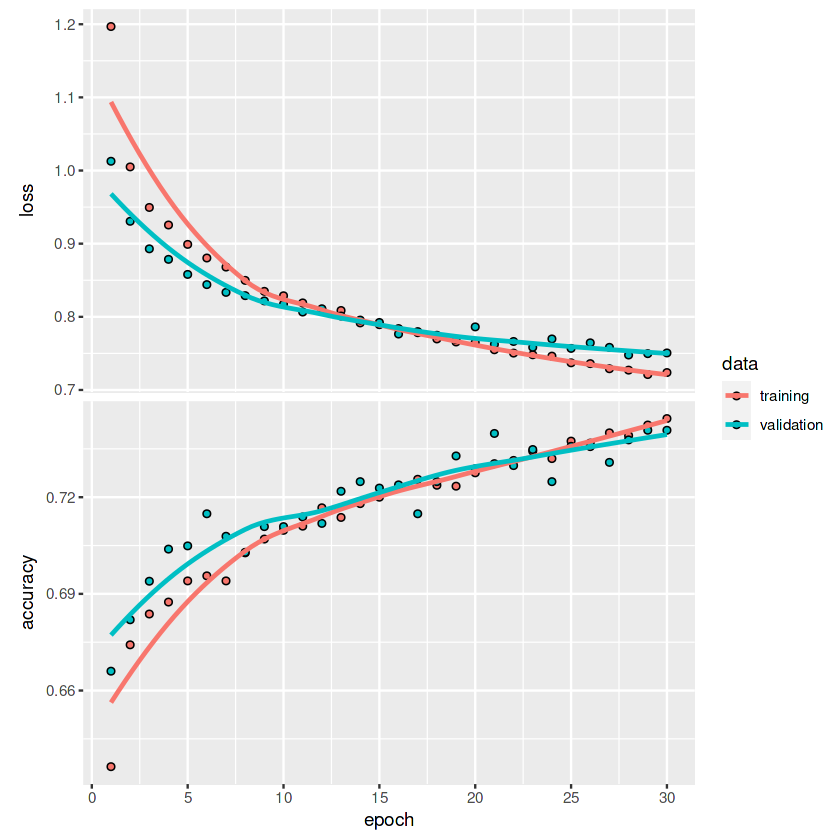

In [88]:
# plot training and validation accuracy over epochs
plot(history)

In [89]:
# get test results
results_fine <- model %>% evaluate(test_pad, Y_test, verbose=0)
results_fine

loss  accuracy 
0.7322934 0.7316708

In [90]:
# compare accuracy to random forest with extracted features
acc_rf

[1] 0.7236908

# CNN Training from scratch

 - train convolutional neural network with self-made model architecture
 - predict classes of test data
 - compare to Random Forest using extracted VGG16 features



In [91]:
# define model architecture of CNN 
batch_size = 128
nb_classes = 7
img_rows = 32
img_cols = 32
kernel_size = c(3, 3)
input_shape = c(img_rows, img_cols, 3)
pool_size = c(2, 2)

model_scratch_project <- keras_model_sequential() %>% 
  # convolutional part of the CNN
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu",input_shape = input_shape) %>% 
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%

  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%
  
  layer_flatten() %>% 

  #fully connected part of the CNN
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = nb_classes, activation = "softmax")

summary(model_scratch_project)

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_3 (Conv2D)                   (None, 32, 32, 16)              448         
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 32, 32, 16)              2320        
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 16, 16, 16)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 16, 16, 32)              4640        
________________________________________________________________________________
conv2d (Conv2D)                     (None, 16, 16, 32)              9248        
________________________________________________________________________________
max_po

In [92]:
# compile model and intitialize weights
model_scratch_project %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

## Training of the CNN model

`geom_smooth()` using formula 'y ~ x'



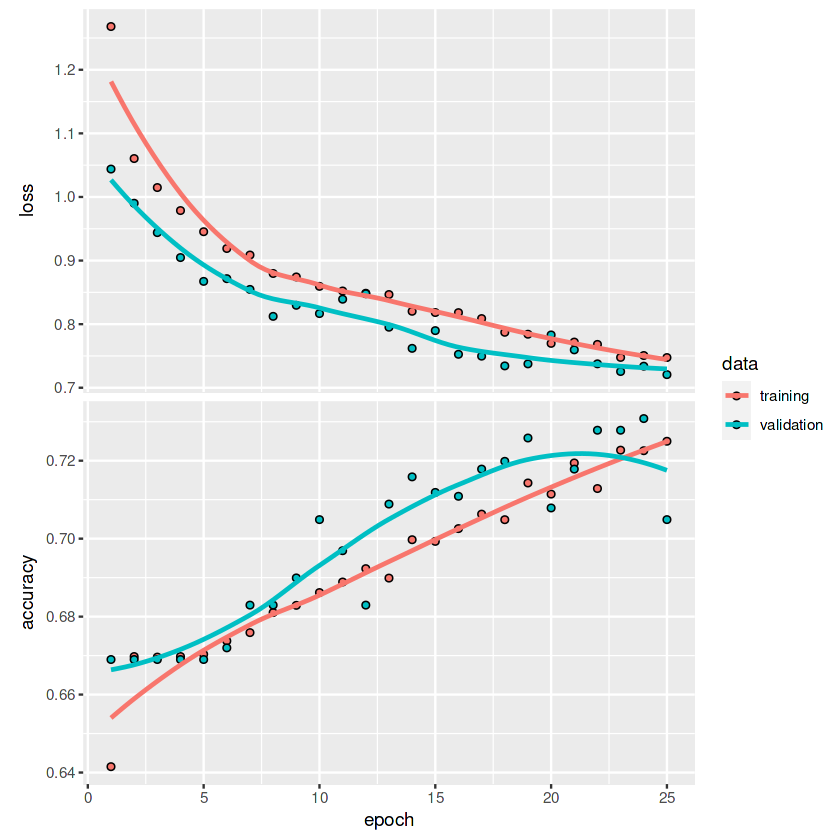

In [93]:
# train CNN model
history <- model_scratch_project %>% fit(
    train_pad, Y_train, 
    epochs = 25,
    batch_size = batch_size,
    verbose = 1,
    validation_data = list(val_pad, Y_val))
plot(history)

In [94]:
# get results on test data
results <- model_scratch_project %>% evaluate(test_pad, Y_test, verbose = 0)
results

loss  accuracy 
0.7365728 0.7177057

In [25]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] randomForest_4.6-14 reticulate_1.26     abind_1.4-5        
 [4] forcats_0.5.2       stringr_1.4.1       dplyr_1.0.10       
 [7] purrr_0.3.4         readr_2.1.2         tidyr_1.2.1        
[10] tibble_3.1.8        ggplot2_3.3.6       tidyverse_1.3.